In [47]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

from matplotlib import cm
import numpy as np
import pandas as pd

In [16]:
print
ff1.Cache.enable_cache('../cache')

plotting.setup_mpl()

In [23]:
# Load the qualifying session for the 2021 Abu Dhabi GP
quali = ff1.get_session(2021, 'Abu Dhabi', 'Q')

# Load session data with laps and telemetry
quali.load(laps=True, telemetry=True)

# Access the laps data
laps = quali.laps  # or laps = quali.load_laps()

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
req            INFO 	Data has been written to cache!
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 22: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  3: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 18: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using ca

In [25]:
laps_ver = laps.pick_driver('VER')
laps_ham = laps.pick_driver('HAM')

# Get the telemetry data from their fastest lap
fastest_ver = laps_ver.pick_fastest().get_telemetry().add_distance()
fastest_ham = laps_ham.pick_fastest().get_telemetry().add_distance()

# Since the telemetry data does not have a variable that indicates the driver, 
# we need to create that column
fastest_ver['Driver'] = 'VER'
fastest_ham['Driver'] = 'HAM'

# Merge both lap telemetries so we have everything in one DataFrame
telemetry = pd.concat([fastest_ver, fastest_ham], ignore_index=True)

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


In [29]:
print(fastest_ver[['X', 'Y', 'Z']].dtypes)
print(fastest_ham[['X', 'Y', 'Z']].dtypes)

# Convert integer columns to float
fastest_ham[['X', 'Y', 'Z']] = fastest_ham[['X', 'Y', 'Z']].astype(float)
print(fastest_ver[['X', 'Y', 'Z']].dtypes)
print(fastest_ham[['X', 'Y', 'Z']].dtypes)

X    float64
Y    float64
Z    float64
dtype: object
X    int64
Y    int64
Z    int64
dtype: object
X    float64
Y    float64
Z    float64
dtype: object
X    float64
Y    float64
Z    float64
dtype: object


In [30]:
# We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

In [31]:

# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

In [32]:
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

In [34]:
# Calculate avg. speed per driver per mini sector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()
print(average_speed)

    Minisector Driver       Speed
0            1    HAM  260.615385
1            1    VER  260.461538
2            2    HAM  233.035714
3            2    VER  236.482759
4            3    HAM  219.600000
5            3    VER  216.766667
6            4    HAM  265.080000
7            4    VER  265.080000
8            5    HAM  279.173913
9            5    VER  279.869565
10           6    HAM  293.652174
11           6    VER  294.869565
12           7    HAM  172.684211
13           7    VER  172.026316
14           8    HAM  199.303030
15           8    VER  198.843750
16           9    HAM  275.826087
17           9    VER  276.458333
18          10    HAM  303.095238
19          10    VER  304.904762
20          11    HAM  314.333333
21          11    VER  317.700000
22          12    HAM  319.428571
23          12    VER  323.761905
24          13    HAM  126.129630
25          13    VER  123.203704
26          14    HAM  204.781250
27          14    VER  202.333333
28          15

In [36]:
# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})
print(fastest_driver)

    Minisector Fastest_driver
0            1            HAM
3            2            VER
4            3            HAM
6            4            HAM
9            5            VER
11           6            VER
12           7            HAM
14           8            HAM
17           9            VER
19          10            VER
21          11            VER
23          12            VER
24          13            HAM
26          14            HAM
29          15            VER
31          16            VER
33          17            VER
34          18            HAM
37          19            VER
39          20            VER
40          21            HAM
43          22            VER
45          23            VER
46          24            HAM
49          25            VER


In [37]:
# Join the fastest driver per minisector with the full telemetry
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == 'VER', 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == 'HAM', 'Fastest_driver_int'] = 2


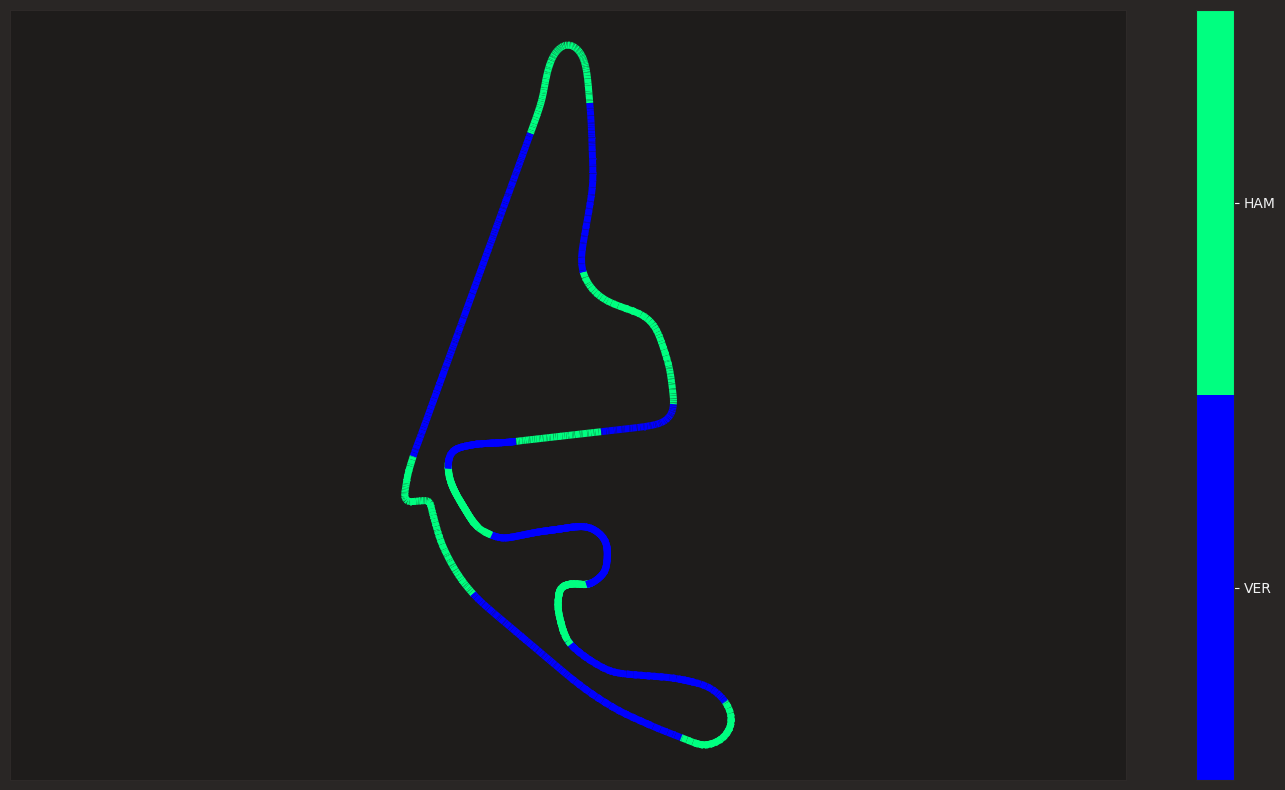

In [48]:
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

# Get the base colormap
base_cmap = plt.colormaps.get_cmap('winter')

# Create a colormap with two discrete colors
cmap = ListedColormap(base_cmap(np.linspace(0, 1, 2)))

lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N + 1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

plt.rcParams['figure.figsize'] = [18, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

# Set the colorbar with two ticks for two drivers
cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1, 4))
cbar.set_ticks([1.5, 2.5])  # Match the number of ticks with the number of labels
cbar.set_ticklabels(['VER', 'HAM'])

plt.savefig("2021_ver_ham_q.png", dpi=300)

plt.show()